In [1]:
source('../load_environment.R')

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Mon Aug 19 14:29:39 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


In [2]:
up <- read.csv("./datasets/MOA_UPurdue.csv") %>%
gather(variable,value,-year:-n_rate)  %>% 
separate(variable,c("stage","organ","measurment","units"),sep = "_")

up$microbe <- factor(up$microbe, levels = c('UTC','PROVEN40'),  labels = c('Uninoculated Control','PROVEN40'))
up$stage <- factor(up$stage, levels = c('V8','R1','R6'))
up$n_rate <- factor(up$n_rate)


In [3]:
up_lt_d15n <- up %>% 
filter(measurment == "d15n",organ == "leaftip")

In [4]:
up_lt_d15n <- up_lt_d15n %>% mutate_at(c("year","rep","microbe","stage","plot","organ"), factor)


In [5]:
# test for HOV across treatments
leveneTest(value ~ microbe, data=up_lt_d15n)
leveneTest(value ~ n_rate, data=up_lt_d15n)
leveneTest(value ~ year, data=up_lt_d15n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,3.168921,0.07668455
,186,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,1.732696,0.1292111
,182,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,1.2148,0.2718077
,186,NA,NA


In [6]:
up_lt_d15n %>% filter(value <= 0)

year,plot,rep,microbe,n_rate,stage,organ,measurment,units,value
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>


In [7]:
up_lt_d15n_mod_full <- lmer(value ~ microbe*n_rate*year +  (1|year:rep:n_rate), data = up_lt_d15n)

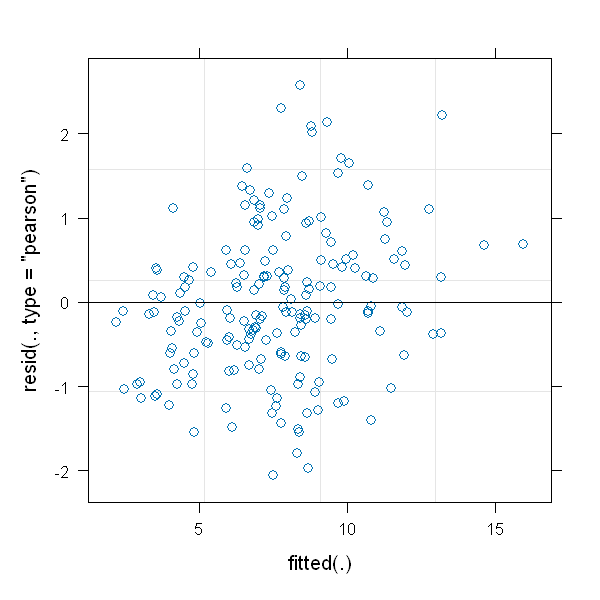

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98959, p-value = 0.1877


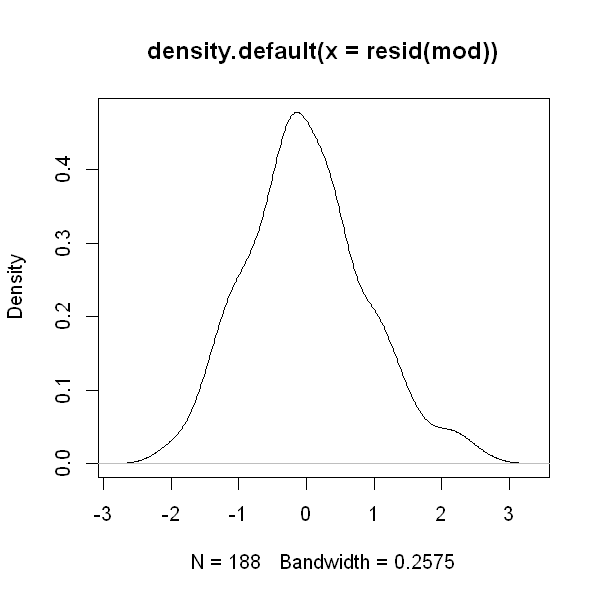

In [8]:
check_assumptions(up_lt_d15n_mod_full)

In [9]:
anova(up_lt_d15n_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
microbe,27.270138,27.2701381,1,82,18.0138954,5.738591e-05
n_rate,37.014207,7.4028414,5,82,4.8901113,5.767334e-04
year,61.488564,61.4885643,1,82,40.6176369,1.021970e-08
microbe:n_rate,4.267136,0.8534273,5,82,0.5637503,7.274687e-01
microbe:year,19.019111,19.0191112,1,82,12.5634963,6.527883e-04
n_rate:year,5.461693,1.0923385,5,82,0.7215685,6.091197e-01
microbe:n_rate:year,7.698758,1.5397515,5,82,1.0171171,4.130445e-01


In [10]:
up_lt_d15n_mod_red1 <- lmer(value ~ microbe*year + n_rate +  (1|year:rep:n_rate), data = up_lt_d15n)

In [11]:
summary(up_lt_d15n_mod_red1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: value ~ microbe * year + n_rate + (1 | year:rep:n_rate)
   Data: up_lt_d15n

REML criterion at convergence: 764.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.90733 -0.51363 -0.08628  0.51516  2.15401 

Random effects:
 Groups          Name        Variance Std.Dev.
 year:rep:n_rate (Intercept) 3.671    1.916   
 Residual                    1.479    1.216   
Number of obs: 188, groups:  year:rep:n_rate, 94

Fixed effects:
                         Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)               12.0572     0.5919  94.9951  20.371  < 2e-16 ***
microbePROVEN40           -1.3996     0.2482  92.0000  -5.639 1.87e-07 ***
year2022                  -3.4222     0.4684 115.5158  -7.306 3.84e-11 ***
n_rate95                  -2.5182     0.7549  87.0000  -3.336 0.001252 ** 
n_rate135                 -2.4088     0.7668  87.0000  -3.141 0.002299 ** 
n_rate

In [12]:
up_lt_d15n_mod <- up_lt_d15n_mod_red1

In [13]:
up_lt_d15n_mod

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: value ~ microbe * year + n_rate + (1 | year:rep:n_rate)
   Data: up_lt_d15n
REML criterion at convergence: 764.1883
Random effects:
 Groups          Name        Std.Dev.
 year:rep:n_rate (Intercept) 1.916   
 Residual                    1.216   
Number of obs: 188, groups:  year:rep:n_rate, 94
Fixed Effects:
             (Intercept)           microbePROVEN40                  year2022  
                  12.057                    -1.400                    -3.422  
                n_rate95                 n_rate135                 n_rate175  
                  -2.518                    -2.409                    -3.262  
               n_rate215                 n_rate255  microbePROVEN40:year2022  
                  -3.226                    -2.871                     1.286  

In [14]:
up_lt_d15n_mod_means <- emmeans(up_lt_d15n_mod, ~ year*microbe,  type = "response")


In [15]:
up_lt_d15n_mod_trt_contrast <- emmeans(up_lt_d15n_mod, ~ microbe, by = c("year"), type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

up_lt_d15n_mod_trt_contrast <- 
up_lt_d15n_mod_trt_contrast %>%
left_join(as.data.frame(up_lt_d15n_mod_means) %>% filter(microbe == "Uninoculated Control") %>% dplyr::select(year,emmean))  %>% 
mutate(ndfa = signif(-estimate/emmean,3)*100,
my_label = 
paste0(
    ifelse(ndfa < 0,"",paste0("Ndfa=",ndfa,"%")),"\n",
    #"(± ",
    #signif(SE,3)*100,
    #"%)\n",
    "p=",signif(p.value,2)
    )
) %>% 
left_join(up_lt_d15n_mod_means %>% 
as.data.frame() %>% 
group_by(year) %>% 
summarize(max_value = max(upper.CL, na.rm = T)))

up_lt_d15n_mod_trt_contrast
 

Joining with `by = join_by(year)`
Joining with `by = join_by(year)`


contrast,year,estimate,SE,df,t.ratio,p.value,emmean,ndfa,my_label,max_value
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
PROVEN40 - Uninoculated Control,2021,-1.3995815,0.2482055,92,-5.6388019,1.867531e-07,9.676354,14.50,Ndfa=14.5% p=1.9e-07,10.32511
PROVEN40 - Uninoculated Control,2022,-0.1134783,0.2535438,92,-0.4475686,6.555166e-01,6.254195,1.81,Ndfa=1.81% p=0.66,6.91744


Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = microbe), :
"Ignoring unknown aesthetics: fill"


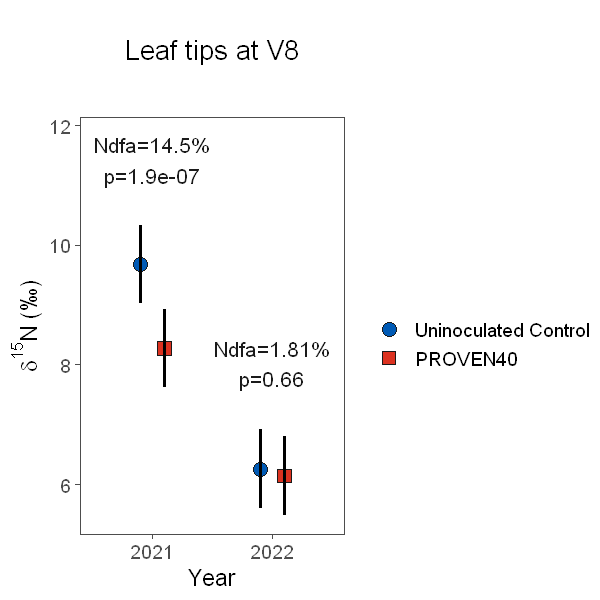

In [16]:
up_lt_plot <- 
as.data.frame(up_lt_d15n_mod_means) %>% 
ggplot(aes(year,emmean)) + 
#geom_point(aes(y = (value), colour = microbe, fill = microbe), data = up21_d15n, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(aes(colour = microbe, fill = microbe, shape = microbe), position = position_dodge(width = 0.4), size = 4, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL,  fill = microbe), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
labs(y = expression(delta^15*N~"(‰)"), x = "Year", colour = "", fill = "", shape = "") + 
scale_fill_manual(values = myColorPalette) +
scale_shape_manual(values = c(21,22)) + 
geom_text(aes(y = (max_value) + 1.5, label = my_label), data = up_lt_d15n_mod_trt_contrast, colour = "gray10", vjust = 1, size = 4.5) + 
ggtitle("\nLeaf tips at V8") + 
facet_wrap(~" ") + 
theme(plot.title = element_text(hjust = 0.5, size = 16))

up_lt_plot

## Field 72 - 2021

In [17]:
up21 <- up %>% filter(year == 2021) 

In [18]:
up21_d15n <- up21 %>% 
filter(measurment == "d15n",organ == "shoot")

# To factor
up21_d15n <- up21_d15n %>% mutate_at(c("year","rep","microbe","stage","plot","organ"), factor)


In [19]:
# test for HOV across treatments
leveneTest(value ~ microbe, data=up21_d15n)
leveneTest(value ~ n_rate, data=up21_d15n)
leveneTest(value ~ stage, data=up21_d15n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,3.508855,0.06206867
,284,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,2.534828,0.02898097
,280,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,125.0047,1.243927e-39
,283,NA,NA


In [20]:
up21_d15n %>% filter(value <= 0)

year,plot,rep,microbe,n_rate,stage,organ,measurment,units,value
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>


In [21]:
leveneTest(log(value) ~ microbe, data=up21_d15n)
leveneTest(log(value) ~ n_rate, data=up21_d15n)
leveneTest(log(value) ~ stage, data=up21_d15n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,1.04317,0.3079545
,284,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,1.347321,0.2445436
,280,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,22.3469,9.750463e-10
,283,NA,NA


In [22]:
up21_d15n_mod_full <- lmer(log(value) ~ microbe*n_rate*stage + (1|rep:n_rate), data = up21_d15n)

In [23]:
summary(up21_d15n_mod_full)


Correlation matrix not shown by default, as p = 36 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(value) ~ microbe * n_rate * stage + (1 | rep:n_rate)
   Data: up21_d15n

REML criterion at convergence: 126

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9993 -0.4634 -0.0450  0.5929  2.3391 

Random effects:
 Groups     Name        Variance Std.Dev.
 rep:n_rate (Intercept) 0.02703  0.1644  
 Residual               0.05748  0.2397  
Number of obs: 286, groups:  rep:n_rate, 48

Fixed effects:
                                   Estimate Std. Error        df t value
(Intercept)                         2.35745    0.10278 165.95897  22.937
microbePROVEN40                    -0.13565    0.11987 208.08654  -1.132
n_rate95                           -0.21219    0.14940 174.30390  -1.420
n_rate135                          -0.45664    0.14535 165.95897  -3.142
n_rate175                          -0.53142    0.14535 165.95897  -3.656
n_rate215                          -0.63379    0.1

In [24]:
up21_d15n_mod_red1 <- lmer(log(value) ~ n_rate*microbe + stage*microbe + stage*n_rate + (1|rep:n_rate), data = up21_d15n)

In [25]:
up21_d15n_mod_red2 <- lmer(log(value) ~ stage*microbe + stage*n_rate + (1|rep:n_rate), data = up21_d15n)

In [26]:
up21_d15n_mod_red3 <- lmer(log(value) ~ stage + microbe + stage*n_rate + (1|rep:n_rate), data = up21_d15n)

In [27]:
anova(up21_d15n_mod_full,up21_d15n_mod_red1,up21_d15n_mod_red2,up21_d15n_mod_red3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
up21_d15n_mod_red3,21,83.44139,160.2172,-20.72069,41.44139,NA,NA,NA
up21_d15n_mod_red2,23,74.80942,158.8972,-14.40471,28.80942,12.631967,2,0.001807187
up21_d15n_mod_red1,28,82.08893,184.4567,-13.04447,26.08893,2.720486,5,0.742983499
up21_d15n_mod_full,38,96.31143,235.2391,-10.15571,20.31143,5.777505,10,0.833596970


In [28]:
up21_d15n_mod <- up21_d15n_mod_red2

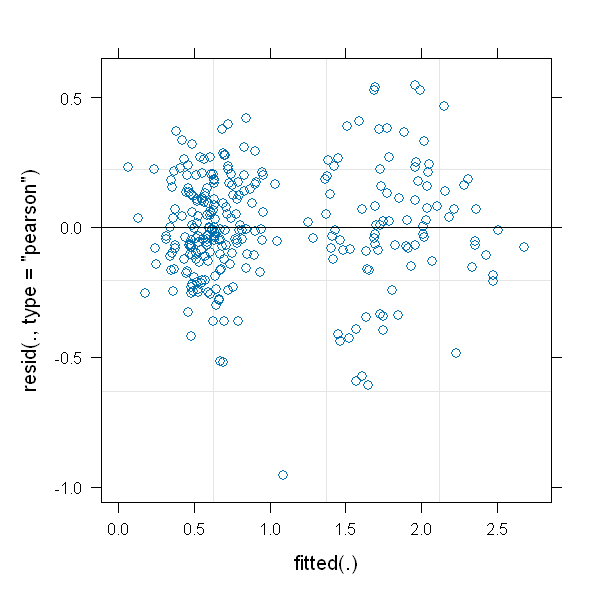

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.9821, p-value = 0.001202


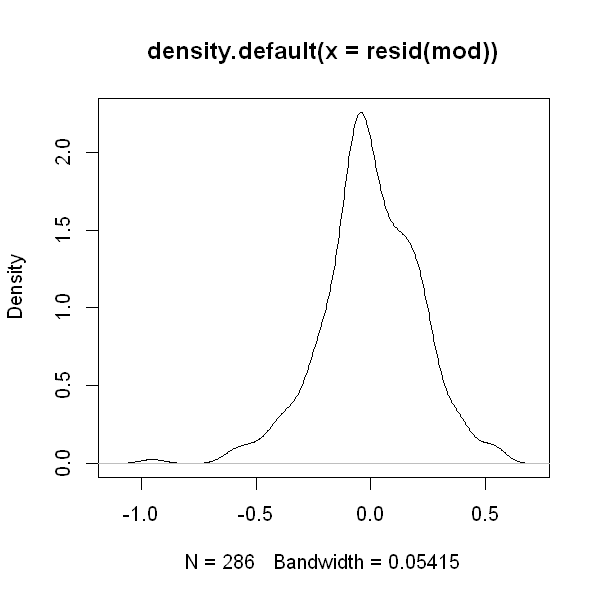

In [29]:
check_assumptions(up21_d15n_mod)

In [30]:
summary(up21_d15n_mod)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(value) ~ stage * microbe + stage * n_rate + (1 | rep:n_rate)
   Data: up21_d15n

REML criterion at convergence: 102.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0518 -0.4485 -0.0397  0.6115  2.3189 

Random effects:
 Groups     Name        Variance Std.Dev.
 rep:n_rate (Intercept) 0.02735  0.1654  
 Residual               0.05556  0.2357  
Number of obs: 286, groups:  rep:n_rate, 48

Fixed effects:
                         Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)               2.44990    0.08650 104.05468  28.323  < 2e-16 ***
stageR1                  -1.72549    0.09008 223.08338 -19.154  < 2e-16 ***
stageR6                  -1.87087    0.09008 223.08338 -20.768  < 2e-16 ***
microbePROVEN40          -0.32054    0.04862 223.08338  -6.592 3.09e-10 ***
n_rate95                 -0.34287    0.12018  96.78590  -2.853 0.005296 ** 
n_rate135             

In [31]:
up21_d15n_mod_means <- emmeans(up21_d15n_mod, ~ stage*microbe,  type = "response")
up21_d15n_mod_means

 stage microbe              response     SE  df lower.CL upper.CL
 V8    Uninoculated Control     7.23 0.3030 168     6.65     7.85
 R1    Uninoculated Control     1.90 0.0790 165     1.75     2.06
 R6    Uninoculated Control     1.98 0.0821 165     1.82     2.14
 V8    PROVEN40                 5.24 0.2199 168     4.83     5.70
 R1    PROVEN40                 1.71 0.0709 165     1.57     1.85
 R6    PROVEN40                 1.75 0.0728 165     1.61     1.90

Results are averaged over the levels of: n_rate 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [32]:
up21_d15n_mod_trt_contrast <- emmeans(up21_d15n_mod, ~ microbe, by = c("stage"), type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

up21_d15n_mod_trt_contrast <- up21_d15n_mod_trt_contrast %>% 
mutate(ndfa = signif(1 - ratio,3)*100,
my_label = 
paste0(
    ifelse(ndfa < 0,"",paste0("Ndfa=",ndfa,"%")),"\n",
    #"(± ",
    #signif(SE,3)*100,
    #"%)\n",
    "p=",signif(p.value,2)
    )
) %>% 
left_join(up21_d15n_mod_means %>% 
as.data.frame() %>% 
group_by(stage) %>% 
summarize(max_value = max(upper.CL, na.rm = T)))

up21_d15n_mod_trt_contrast 

Joining with `by = join_by(stage)`


contrast,stage,ratio,SE,df,null,t.ratio,p.value,ndfa,my_label,max_value
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
PROVEN40 / Uninoculated Control,V8,0.7257583,0.03528989,223.0124,1,-6.592068,3.093963e-10,27.4,Ndfa=27.4% p=3.1e-10,7.849943
PROVEN40 / Uninoculated Control,R1,0.8976056,0.04318890,223.0124,1,-2.245099,2.574280e-02,10.2,Ndfa=10.2% p=0.026,2.062464
PROVEN40 / Uninoculated Control,R6,0.8871582,0.04268622,223.0124,1,-2.488419,1.356284e-02,11.3,Ndfa=11.3% p=0.014,2.144491


Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = microbe), :
"Ignoring unknown aesthetics: fill"


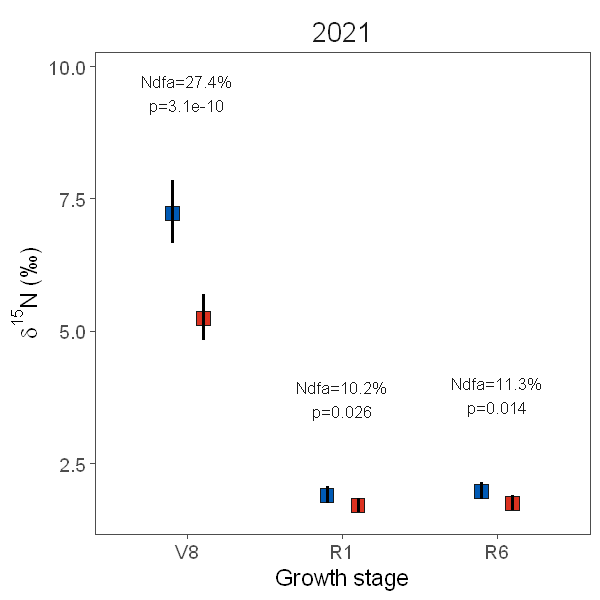

In [33]:
up21_plot <- 
as.data.frame(up21_d15n_mod_means) %>% 
ggplot(aes(stage,response)) + 
#geom_point(aes(y = (value), colour = microbe, fill = microbe), data = up21_d15n, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(aes(colour = microbe, fill = microbe), position = position_dodge(width = 0.4), size = 4, shape = 22, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL,  fill = microbe), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
labs(y = expression(delta^15*N~"(‰)"), x = "Growth stage", colour = "", fill = "") + 
scale_fill_manual(values = myColorPalette) +
geom_text(aes(y = (max_value) + 2, label = my_label), data = up21_d15n_mod_trt_contrast, colour = "gray10", vjust = 1, size = 3.5) + 
facet_wrap(~"2021") + 
theme(legend.position = "none")

up21_plot

## 2022

In [34]:
up22 <- up %>% filter(year == 2022)

In [35]:
up22_d15n <- up22 %>% 
filter(measurment == "d15n",organ == "shoot")

# To factor
up22_d15n <- up22_d15n %>% mutate_at(c("year","rep","microbe","stage","plot","organ"), factor)


In [36]:
up22_d15n %>% filter(value <= 0)
up22_d15n <- up22_d15n %>% filter(value > 0)
# offset constant set so min(y) = 1
#(a = 1 - min(up22_d15n$value, na.rm =  T))


year,plot,rep,microbe,n_rate,stage,organ,measurment,units,value
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<dbl>
2022,109,1,PROVEN40,255,V8,shoot,d15n,permil,-0.7831686


In [37]:
str(up22_d15n)

'data.frame':	275 obs. of  10 variables:
 $ year      : Factor w/ 1 level "2022": 1 1 1 1 1 1 1 1 1 1 ...
 $ plot      : Factor w/ 92 levels "101","102","103",..: 1 2 3 4 5 6 7 8 10 11 ...
 $ rep       : Factor w/ 8 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ microbe   : Factor w/ 2 levels "Uninoculated Control",..: 2 1 2 1 2 1 2 1 1 2 ...
 $ n_rate    : Factor w/ 6 levels "0","95","135",..: 5 5 4 4 3 3 1 1 6 2 ...
 $ stage     : Factor w/ 3 levels "V8","R1","R6": 1 1 1 1 1 1 1 1 1 1 ...
 $ organ     : Factor w/ 1 level "shoot": 1 1 1 1 1 1 1 1 1 1 ...
 $ measurment: chr  "d15n" "d15n" "d15n" "d15n" ...
 $ units     : chr  "permil" "permil" "permil" "permil" ...
 $ value     : num  3.1 4.29 3.76 2.78 5.93 ...


In [38]:
# test for HOV across treatments
leveneTest(value ~ microbe, data=up22_d15n)
leveneTest(value ~ n_rate, data=up22_d15n)
leveneTest(value ~ stage, data=up22_d15n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,1.081414,0.2993015
,273,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,2.787297,0.01789965
,269,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,50.49465,2.242153e-19
,272,NA,NA


In [39]:
leveneTest(log(value) ~ microbe, data=up22_d15n)
leveneTest(log(value) ~ n_rate, data=up22_d15n)
leveneTest(log(value) ~ stage, data=up22_d15n)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.4245594,0.5152189
,273,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,5,0.490315,0.7834003
,269,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,3.293316,0.0386166
,272,NA,NA


In [40]:
up22_d15n_mod_full <- lmer(log(value) ~ microbe*n_rate*stage + (1|rep/n_rate) + (1|plot), data = up22_d15n)

boundary (singular) fit: see help('isSingular')



In [41]:
anova(up22_d15n_mod_full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
microbe,0.2124747,0.21247469,1,199.38992,1.2443038,2.659858e-01
n_rate,10.9415597,2.18831194,5,33.16485,12.8152907,5.668990e-07
stage,117.9573194,58.97865969,2,199.38880,345.3934766,1.663685e-65
microbe:n_rate,1.1415532,0.22831064,5,199.39310,1.3370431,2.500746e-01
microbe:stage,1.5247131,0.76235653,2,199.38880,4.4645465,1.268332e-02
n_rate:stage,6.5859971,0.65859971,10,199.38803,3.8569212,8.576037e-05
microbe:n_rate:stage,0.5621746,0.05621746,10,199.38803,0.3292232,9.725444e-01


In [42]:
up22_d15n_mod_red1 <- lmer(log(value) ~ n_rate*microbe + stage*microbe + stage*n_rate  + (1|rep/n_rate), data = up22_d15n)

In [43]:
up22_d15n_mod_red2 <- lmer(log(value) ~ stage*microbe + stage*n_rate  + (1|rep/n_rate), data = up22_d15n)

In [44]:
up22_d15n_mod_red3 <- lmer(log(value) ~ stage + microbe + stage*n_rate  + (1|rep/n_rate), data = up22_d15n)

In [45]:
anova(up22_d15n_mod_full,up22_d15n_mod_red1,up22_d15n_mod_red2,up22_d15n_mod_red3)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
up22_d15n_mod_red3,22,360.1271,439.6961,-158.0636,316.1271,NA,NA,NA
up22_d15n_mod_red2,24,354.4384,441.2409,-153.2192,306.4384,9.688690,2,0.007872771
up22_d15n_mod_red1,29,356.9981,461.8844,-149.4990,298.9981,7.440375,5,0.189894308
up22_d15n_mod_full,40,375.2417,519.9125,-147.6209,295.2417,3.756360,11,0.976509735


In [46]:
up22_d15n_mod <- up22_d15n_mod_red2

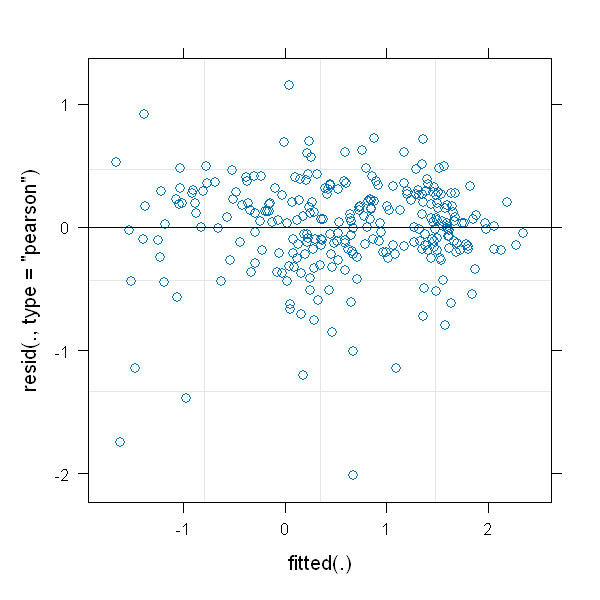

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.92366, p-value = 1.155e-10


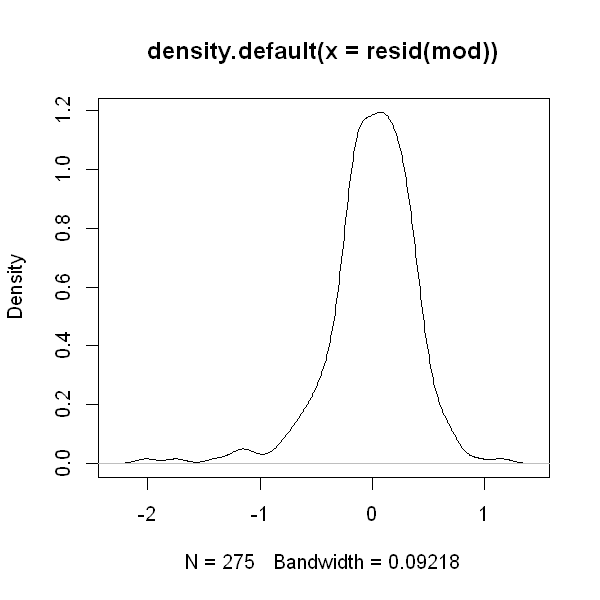

In [47]:
check_assumptions(up22_d15n_mod)

In [48]:
summary(up22_d15n_mod)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(value) ~ stage * microbe + stage * n_rate + (1 | rep/n_rate)
   Data: up22_d15n

REML criterion at convergence: 359.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9289 -0.4388  0.0883  0.5946  2.8203 

Random effects:
 Groups     Name        Variance Std.Dev.
 n_rate:rep (Intercept) 0.005434 0.07372 
 rep        (Intercept) 0.325662 0.57067 
 Residual               0.166792 0.40840 
Number of obs: 275, groups:  n_rate:rep, 46; rep, 8

Fixed effects:
                         Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)               1.51456    0.23533  12.46261   6.436 2.70e-05 ***
stageR1                  -1.05034    0.16576 214.22947  -6.337 1.37e-09 ***
stageR6                  -0.49622    0.16576 214.22947  -2.994  0.00308 ** 
microbePROVEN40           0.20895    0.08568 214.78773   2.439  0.01555 *  
n_rate95                 -0.47524    0.15472 162

In [49]:
up22_d15n_mod_means <- emmeans(up22_d15n_mod, ~ stage*microbe,  type = "response")
up22_d15n_mod_means

 stage microbe              response    SE   df lower.CL upper.CL
 V8    Uninoculated Control    2.893 0.610 8.06    1.780     4.70
 R1    Uninoculated Control    0.787 0.166 8.06    0.484     1.28
 R6    Uninoculated Control    2.495 0.526 8.06    1.535     4.06
 V8    PROVEN40                3.565 0.753 8.09    2.193     5.79
 R1    PROVEN40                0.680 0.143 8.06    0.418     1.10
 R6    PROVEN40                2.790 0.588 8.06    1.716     4.53

Results are averaged over the levels of: n_rate 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [50]:
up22_d15n_mod_means

 stage microbe              response    SE   df lower.CL upper.CL
 V8    Uninoculated Control    2.893 0.610 8.06    1.780     4.70
 R1    Uninoculated Control    0.787 0.166 8.06    0.484     1.28
 R6    Uninoculated Control    2.495 0.526 8.06    1.535     4.06
 V8    PROVEN40                3.565 0.753 8.09    2.193     5.79
 R1    PROVEN40                0.680 0.143 8.06    0.418     1.10
 R6    PROVEN40                2.790 0.588 8.06    1.716     4.53

Results are averaged over the levels of: n_rate 
Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [51]:
up22_d15n_mod_trt_contrast <- emmeans(up22_d15n_mod, ~ microbe, by = c("stage"), type = "response") %>% 
pairs(reverse = TRUE,  adjust = "Tukey") %>% 
data.frame()

up22_d15n_mod_trt_contrast <- up22_d15n_mod_trt_contrast %>% 
mutate(ndfa = signif(1 - ratio,3)*100,
my_label = 
paste0(
    ifelse(ndfa < 0,"",paste0("Ndfa=",ndfa,"%")),"\n",
    #"(± ",
    #signif(SE,3)*100,
    #"%)\n",
    "p=",signif(p.value,2)
    )
) %>% 
left_join(up22_d15n_mod_means %>% 
as.data.frame() %>% 
group_by(stage) %>% 
summarize(max_value = max(upper.CL, na.rm = T)))

up22_d15n_mod_trt_contrast 

Joining with `by = join_by(stage)`


contrast,stage,ratio,SE,df,null,t.ratio,p.value,ndfa,my_label,max_value
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
PROVEN40 / Uninoculated Control,V8,1.2323806,0.10560023,214.614,1,2.438472,0.01556250,-23.2,p=0.016,5.794875
PROVEN40 / Uninoculated Control,R1,0.8640633,0.07358159,214.013,1,-1.715751,0.08765486,13.6,Ndfa=13.6% p=0.088,1.278412
PROVEN40 / Uninoculated Control,R6,1.1178537,0.09519378,214.013,1,1.308286,0.19217979,-11.8,p=0.19,4.534030


In [52]:
up22_plot <- 
as.data.frame(up22_d15n_mod_means) %>% 
ggplot(aes(stage,response)) + 
#geom_point(aes(y = (value), colour = microbe, fill = microbe), data = up22_d15n, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(aes(colour = microbe, fill = microbe, shape = microbe), position = position_dodge(width = 0.4), size = 4, colour = "gray10") +
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL,  fill = microbe), width = 0, position = position_dodge(width = 0.4), lwd = 1) + 
labs(y = expression(delta^15*N~"(‰)"), x = "Growth stage", colour = "", fill = "") + 
geom_text(aes(y = (max_value) + 1.5, label = my_label), data = up22_d15n_mod_trt_contrast, colour = "gray10", vjust = 1, size = 3.5) + 
scale_fill_manual(values = myColorPalette) +
scale_shape_manual(values = c(21,22)) + 
facet_wrap(~"2022") + 
theme(legend.position = "none")

Warning message in geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL, fill = microbe), :
"Ignoring unknown aesthetics: fill"


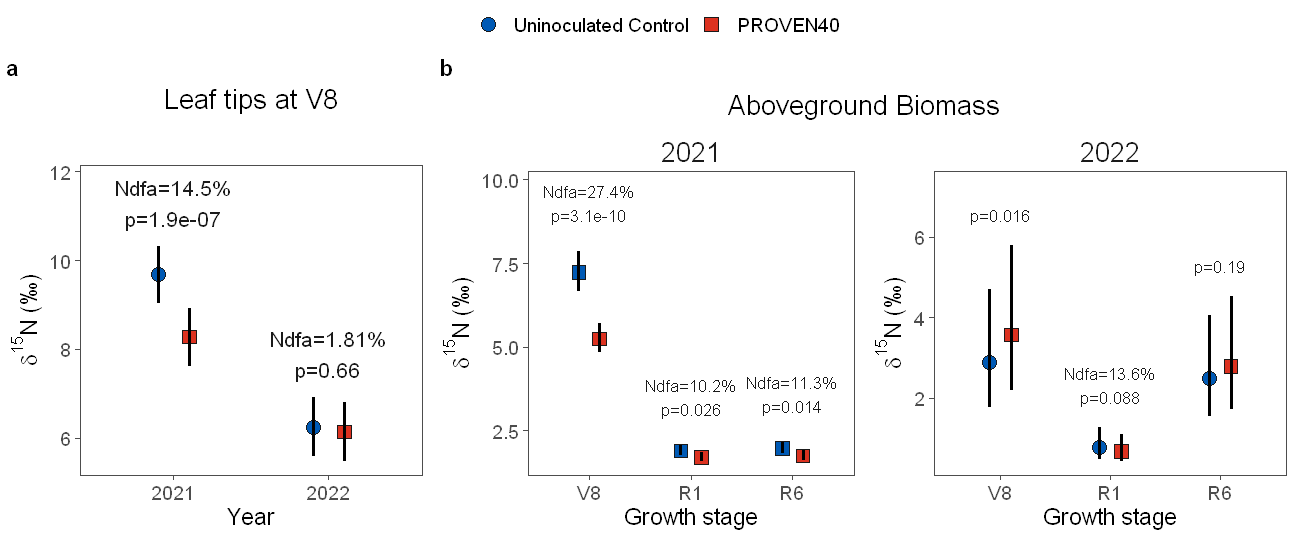

In [53]:
options(repr.plot.width=12*0.9, repr.plot.height=5*0.9)

ggarrange(
    up_lt_plot,
    annotate_figure(ggarrange(up21_plot,up22_plot, nrow = 1), top = text_grob("\nAboveground Biomass", size = 16)),
    nrow = 1, common.legend = T,
    widths = c(1,2),  labels = c("a","b"))

In [54]:
ggsave("./figures/d15n_natural_abundance.png",width = 12*0.9, height = 5*0.9, dpi = 300, bg = "white")

In [55]:
bind_rows(
    up21_d15n_mod_trt_contrast %>% mutate(year = 2021),
    up22_d15n_mod_trt_contrast %>% mutate(year = 2022)
) %>%
saveRDS("./datasets/UPurdue_whole_plant_d15n.rds")
